# **Example Usage of Pangeo-Fish Software with Healpix Convolution**


**Overview:**
This Jupyter notebook demonstrates the usage of the Pangeo-Fish software, a tool designed for analyzing biologging data in reference to Earth Observation (EO) data. Specifically, it utilizes data employed in the study conducted by M. Gonze et al. titled "Combining acoustic telemetry with archival tagging to investigate the spatial dynamics of the understudied pollack *Pollachius pollachius*," accepted for publication in the Journal of Fish Biology.

We showcase the application using the biologging tag 'A19124' attached to a pollack fish, along with reference EO data from the European Union Copernicus Marine Service Information (CMEMS) product 'NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013'. The biologging data consist of Data Storage Tag (DST) and teledetection by acoustic signals, along with release and recapture time and location of the species in question.  Both biologging data and the reference EO data are accessible with https and the access methods are incropolated in this notebook.   



**Purpose:**
By executing this notebook, users will learn how to set up a workflow for utilizing the Pangeo-Fish software. The workflow consists of 9 steps which are described below:

1. **Configure the Notebook:** Prepare the notebook environment for analysis.
2. **Compare Reference Model with DST Information:** Analyze and compare data from the reference model with information from the biologging data of the species in question. 
3. **Regrid the Grid from Reference Model Grid to Healpix Grid:** Transform the grid from the reference model to the Healpix grid for further analysis.
4. **Construct Emission Matrix:** Create an emission matrix based on the transformed grid.
5. **Compute Additional Emission Probability Matrix:** Calculate an additional emission probability matrix, particularly focusing on teledetection from acoustic signals.
6. **Combine and Normalize Emission Matrix:** Merge the emission matrix and normalize it for further processing.
7. **Estimate Model Parameters:** Determine the parameters of the model based on the normalized emission matrix.
8. **Compute State Probabilities and Tracks:** Calculate the probability distribution of the species in question and compute the tracks.
9. **Visualization:** Visualize the results of the analysis for interpretation and insight.

Throughout this notebook, users will gain practical experience in setting up and executing a workflow using Pangeo-Fish, enabling them to apply similar methodologies to their own biologging data analysis tasks.



## 1. **Configure the Notebook:** Prepare the notebook environment for analysis.

In this step, we sets up the notebook environment for analysis. It includes installing necessary packages, importing required libraries, setting up parameters, and configuring the cluster for distributed computing. It also retrieves the tag data needed for analysis.

    

In [12]:
# Import necessary libraries and modules.
import xarray as xr
from pint_xarray import unit_registry as ureg
from pangeo_fish.io import open_tag

In [13]:
#
# Set up execution parameters for the analysis.
#
# Note: This cell is tagged as parameters, allowing automatic updates when configuring with papermil.

# tag_name corresponds to the name of the biologging tag name (DST identification number),
# which is also a path for storing all the information for the specific fish tagged with tag_name.
tag_name = "A19124"

# tag_root specifies the root URL for tag data used for this computation.
tag_root = "https://data-taos.ifremer.fr/data_tmp/cleaned/tag/"

# catalog_url specifies the URL for the catalog for reference data used.
catalog_url = "https://data-taos.ifremer.fr/kerchunk/ref-copernicus.yaml"
open_catalog = True


# scratch_root specifies the root directory for storing output files.
scratch_root = "s3://destine-gfts-data-lake/demo"

# storage_options specifies options for the filesystem storing output files.
storage_options = {
    "anon": False,
    "profile": "gfts",
    "client_kwargs": {
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
        "region_name": "gra",
    },
}

# if you are using local file system, activate following two lines
scratch_root = "."
storage_options = None

# Default chunk value for time dimension.  This values depends on the configuration of your dask cluster.
chunk_time = 24

#
# Parameters for step 2. **Compare Reference Model with DST Information:**
#
# bbox, bounding box, defines the latitude and longitude range for the analysis area.
bbox = {"latitude": [46, 51], "longitude": [-8, -1]}

# relative_depth_threshold defines the acceptable fish depth relative to the maximum tag depth.
# It determines whether the fish can be considered to be in a certain location based on depth.
relative_depth_threshold = 0.8

#
# Parameters for step 3. **Regrid the Grid from Reference Model Grid to Healpix Grid:**
#
# nside defines the resolution of the healpix grid used for regridding.
nside = 4096  # *2

# min_vertices sets the minimum number of vertices for a valid transcription for regridding.
min_vertices = 1

#
# Parameters for step 4. **Construct Emission Matrix:**
#
# differences_std sets the standard deviation for scipy.stats.norm.pdf.
# It expresses the estimated certainty of the field of difference.
differences_std = 0.75

# recapture_std sets the covariance for recapture event.
# It shows the certainty of the final recapture area if it is known.
recapture_std = 1e-2

# earth_radius defines the radius of the Earth used for distance calculations.
earth_radius = ureg.Quantity(6371, "km")

# maximum_speed sets the maximum allowable speed for the tagged fish.
maximum_speed = ureg.Quantity(60, "km / day")

# adjustment_factor adjusts parameters for a more fuzzy search.
# It will factor the allowed maximum displacement of the fish.
adjustment_factor = 5

# truncate sets the truncating factor for computed maximum allowed sigma for convolution process.
truncate = 4

#
# Parameters for step 5. **Compute Additional Emission Probability Matrix:**
#
# receiver_buffer sets the maximum allowed detection distance for acoustic receivers.
receiver_buffer = ureg.Quantity(1000, "m")

#
# Parameters for step 7. **Estimate Model Parameters:**
#
# tolerance sets the tolerance level for optimised parameter serarch computation.
tolerance = 1e-6

#
# Parameters for step 8. **Compute State Probabilities and Tracks:**
#
# track_modes defines the modes for track calculation.
track_modes = ["mean", "mode"]
#track_modes = ["mean", "mode","mode_minrk","mean_minrk"]

# additional_track_quantities sets quantities to compute for tracks using moving pandas.
additional_track_quantities = ["speed", "distance"]


#
# Parameters for step 9. **Visualization:**
#
# time_step defines for each time_step value we make movie of state and emission matrix
time_step = 3

In [14]:
# Define target root directories for storing analysis results.
target_root = f"{scratch_root}/{tag_name}"

# Defines default chunk size for optimisation.
default_chunk = {"time": chunk_time, "lat": -1, "lon": -1}
default_chunk_xy = {"time": chunk_time, "x": -1, "y": -1}
default_chunk_cells = {"time": chunk_time, "cells": -1}

In [15]:
# Set up a local cluster for distributed computing.
from distributed import LocalCluster

cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 24.46 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38819,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 24.46 GiB
Comm: tcp://127.0.0.1:33499,Total threads: 4
Dashboard: http://127.0.0.1:36585/status,Memory: 6.11 GiB
Nanny: tcp://127.0.0.1:44729,


2025-01-31 11:17:50,983 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('open_dataset-cell_ids-6fb987057a0da8a415e68a014542f645', 0) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: memory
old run_spec: (<function getter at 0x7f6a19f5eac0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7f68da613a40>, key=BasicIndexer((slice(None, None, None),))))), (slice(0, 111617, None),)), {})
new run_spec: (<function getter at 0x7f6a19f5eac0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.ba

In [16]:
tag_root

'https://data-taos.ifremer.fr/data_tmp/cleaned/tag/'

In [17]:
# Open and retrieve the tag data required for the analysis
tag = open_tag(tag_root, tag_name)
tag

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       pit_tag_id:       A19124
│       acoustic_tag_id:  OPI-372
│       scientific_name:  Pollachius pollachius
│       common_name:      Pollock
│       project:          FISHINTEL
├── DataTree('dst')
│       Dimensions:      (time: 20680)
│       Coordinates:
│         * time         (time) datetime64[ns] 165kB 2022-06-12T22:00:00 ... 2022-07-...
│       Data variables:
│           temperature  (time) float64 165kB 17.58 17.53 17.5 ... 20.53 20.55 20.66
│           pressure     (time) float64 165kB 1.43 1.43 1.43 1.5 ... 1.81 1.81 1.81 1.81
├── DataTree('tagging_events')
│       Dimensions:     (event_name: 2)
│       Coordinates:
│         * event_name  (event_name) object 16B 'release' 'fish_death'
│       Data variables:
│           time        (event_name) datetime64[ns] 16B 2022-06-13T11:40:30 2022-06-2...
│           longitude   (event_name) float64 16B -5.098 -5.136
│           latitude    (event_name) float64 16B 48.45 48.43
├── DataTree('stations')
│       Dimensions:            (deployment_id: 41)
│       Coordinates:
│         * deployment_id      (deployment_id) int64 328B 28689 28690 ... 29666 59010
│       Data variables:
│           station_name       (deployment_id) object 328B 'ancrage_mahuda' ... 'stiff'
│           deploy_time        (deployment_id) datetime64[ns] 328B 2022-06-13T06:14:0...
│           deploy_longitude   (deployment_id) float64 328B -5.103 -5.112 ... -5.025
│           deploy_latitude    (deployment_id) float64 328B 48.45 48.45 ... 48.47 48.47
│           recover_time       (deployment_id) datetime64[ns] 328B 2022-06-20T14:07:0...
│           recover_longitude  (deployment_id) float64 328B nan nan nan ... nan nan nan
│           recover_latitude   (deployment_id) float64 328B nan nan nan ... nan nan nan
└── DataTree('acoustic')
        Dimensions:        (time: 48)
        Coordinates:
          * time           (time) datetime64[ns] 384B 2022-06-13T13:41:49 ... 2022-06...
        Data variables:
            deployment_id  (time) int64 384B 28689 28689 28690 ... 28690 28690 28690
            longitude      (time) float64 384B -5.103 -5.103 -5.112 ... -5.112 -5.112
            latitude       (time) float64 384B 48.45 48.45 48.45 ... 48.45 48.45 48.45

## 2. **Compare Reference Model with DST Tag Information:** Analyze and compare data from the reference model with information from the biologging data of the species in question. 

In this step, we compare the reference model data with Data Storage Tag information.
The process involves reading and cleaning the reference model, aligning time, converting depth units, subtracting tag data from the model, and saving the results.

In [ ]:
# Import necessary libraries
import intake
from pangeo_fish.cf import bounds_to_bins
from pangeo_fish.diff import diff_z
from pangeo_fish.io import open_copernicus_catalog
from pangeo_fish.tags import adapt_model_time, reshape_by_bins, to_time_slice

In [ ]:
# Drop tag data outside the tagged events interval
time_slice = to_time_slice(tag["tagging_events/time"])
tag_log = tag["dst"].ds.sel(time=time_slice)

# Verify the data
import hvplot.xarray
import cmocean
from pangeo_fish.io import save_html_hvplot

plot = (
    (-tag["dst"].pressure).hvplot(width=1000, height=500, color="blue")
    * (-tag_log).hvplot.scatter(
        x="time", y="pressure", color="red", size=5, width=1000, height=500
    )
    * (
        (tag["dst"].temperature).hvplot(width=1000, height=500, color="blue")
        * (tag_log).hvplot.scatter(
            x="time", y="temperature", color="red", size=5, width=1000, height=500
        )
    )
)
filepath = f"{target_root}/tags.html"

save_html_hvplot(plot, filepath, storage_options)

plot

In [ ]:
# Open and clean reference model
if open_catalog:
    cat = intake.open_catalog(catalog_url)
    model = open_copernicus_catalog(cat)
else:
    from pangeo_fish.io import open_copernicus_zarr

    model = open_copernicus_zarr(
        # model='GLOBAL_ANALYSISFORECAST_PHY_001_024',
        # freq="D",
    )

In [ ]:
# Subset the reference_model by
# - align model time with the time of tag_log, also
# - drop data for depth later that are unlikely due to the observed pressure from tag_log
# - defined latitude and longitude of bbox.
#
reference_model = (
    model.sel(time=adapt_model_time(time_slice))
    .sel(lat=slice(*bbox["latitude"]), lon=slice(*bbox["longitude"]))
    .pipe(
        lambda ds: ds.sel(
            depth=slice(None, (tag_log["pressure"].max() - ds["XE"].min()).compute())
        )
    )
).chunk({"time": chunk_time, "lat": -1, "lon": -1, "depth": -1})
reference_model

In [ ]:
%%time
# Reshape the tag log, so that it bins to the time step of reference_model
reshaped_tag = reshape_by_bins(
    tag_log,
    dim="time",
    bins=(
        reference_model.cf.add_bounds(["time"], output_dim="bounds")
        .pipe(bounds_to_bins, bounds_dim="bounds")
        .get("time_bins")
    ),
    bin_dim="bincount",
    other_dim="obs",
).chunk({"time": chunk_time})

In [ ]:
# Subtract the time_bined tag_log from the reference_model.
# Here, for each time_bin, each observed value are compared with the correspoindng depth of reference_model using diff_z function.
#
diff = (
    diff_z(reference_model, reshaped_tag, depth_threshold=relative_depth_threshold)
    .assign_attrs({"tag_id": tag_name})
    .assign(
        {
            "H0": reference_model["H0"],
            "ocean_mask": reference_model["H0"].notnull(),
        }
    )
)

# Persist the diff data
diff = diff.chunk(default_chunk).persist()
diff

In [ ]:
# Verify the data
diff["diff"].count(["lat", "lon"]).plot()

In [ ]:
%%time
# Save snapshot to disk
diff.to_zarr(f"{target_root}/diff.zarr", mode="w", storage_options=storage_options)

# Cleanup
del tag_log, cat, model, reference_model, reshaped_tag, diff

## 3. **Regrid the Grid from Reference Model Grid to Healpix Grid:** Transform the grid from the reference model to the Healpix grid for further analysis.

In this step, we regrid the data from the reference model grid to a Healpix grid. This process involves defining the Healpix grid, creating the target grid, computing interpolation weights, performing the regridding, and saving the regridded data.


In [18]:
# Import necessary libraries
import numpy as np
from xarray_healpy import HealpyGridInfo, HealpyRegridder
from pangeo_fish.grid import center_longitude

In [19]:
%%time

# Open the diff data and performs cleaning operations to prepare it for regridding.

ds = (
    xr.open_dataset(
        f"{target_root}/diff.zarr",
        engine="zarr",
        chunks={},
        storage_options=storage_options,
    )
    .pipe(lambda ds: ds.merge(ds[["latitude", "longitude"]].compute()))
    .swap_dims({"lat": "yi", "lon": "xi"})
    .drop_vars(["lat", "lon"])
)
# Trouver les valeurs minimales et maximales en ignorant les NaN
min_diff = ds['diff'].min(skipna=True).compute()
max_diff = ds['diff'].max(skipna=True).compute()

print(f"Valeur minimale de diff (en ignorant NaN) : {min_diff}")
print(f"Valeur maximale de diff (en ignorant NaN) : {max_diff}")

Valeur minimale de diff (en ignorant NaN) : <xarray.DataArray 'diff' ()> Size: 8B
array(-9.99578125)
Valeur maximale de diff (en ignorant NaN) : <xarray.DataArray 'diff' ()> Size: 8B
array(2.266675)
CPU times: user 105 ms, sys: 34.4 ms, total: 140 ms
Wall time: 1.44 s


In [20]:
%%time
# Define the target Healpix grid information
grid = HealpyGridInfo(level=int(np.log2(nside)))
target_grid = grid.target_grid(ds).pipe(center_longitude, 0)
target_grid

CPU times: user 25.4 ms, sys: 886 μs, total: 26.3 ms
Wall time: 16.2 ms


<xarray.Dataset> Size: 3MB
Dimensions:     (cells: 111617)
Coordinates:
    cell_ids    (cells) uint64 893kB 56064943 56064954 ... 57955392 57955456
    latitude    (cells) float64 893kB 46.02 46.03 46.02 ... 50.98 50.98 50.98
    longitude   (cells) float64 893kB -1.066 -1.042 -3.078 ... -7.507 -7.722
    resolution  float64 8B 0.0002498
Dimensions without coordinates: cells
Data variables:
    *empty*
Attributes:
    grid_type:  healpix
    level:      12
    nside:      4096
    lat:        0
    lon:        0
    rot_lat:    0
    rot_lon:    0

In [21]:
%%time
# Compute the interpolation weights for regridding the diff data
regridder = HealpyRegridder(
    ds[["longitude", "latitude", "ocean_mask"]],
    target_grid,
    method="bilinear",
    interpolation_kwargs={"mask": "ocean_mask", "min_vertices": min_vertices},
)
regridder

CPU times: user 3.4 s, sys: 79.6 ms, total: 3.48 s
Wall time: 3.5 s


/home/ecap/micromamba/envs/pangeo-fish/lib/python3.11/site-packages/xarray_healpy/interpolation/mask.py:22: RuntimeWarning: invalid value encountered in divide
  return masked_weights / np.sum(masked_weights, axis=-1)[:, None]


HealpyRegridder(method='bilinear', interpolation_kwargs={'mask': 'ocean_mask', 'min_vertices': 1})

In [22]:
%%time
# Perform the regridding operation using the computed interpolation weights.
regridded = regridder.regrid_ds(ds).assign_coords(cell_ids= lambda ds: ds.cell_ids.astype('int64') )
regridded

CPU times: user 1.89 s, sys: 323 ms, total: 2.22 s
Wall time: 2.18 s


<xarray.Dataset> Size: 235MB
Dimensions:     (cells: 111617, time: 258)
Coordinates:
    cell_ids    (cells) int64 893kB 56064943 56064954 ... 57955392 57955456
    latitude    (cells) float64 893kB 46.02 46.03 46.02 ... 50.98 50.98 50.98
    longitude   (cells) float64 893kB -1.066 -1.042 -3.078 ... -7.507 -7.722
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    H0          (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    diff        (time, cells) float64 230MB dask.array<chunksize=(24, 111617), meta=np.ndarray>
    ocean_mask  (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    level:      12
    nside:      4096
    lat:        0
    lon:        0
    rot_lat:    0
    rot_lon:    0

/home/ecap/micromamba/envs/pangeo-fish/lib/python3.11/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 13.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


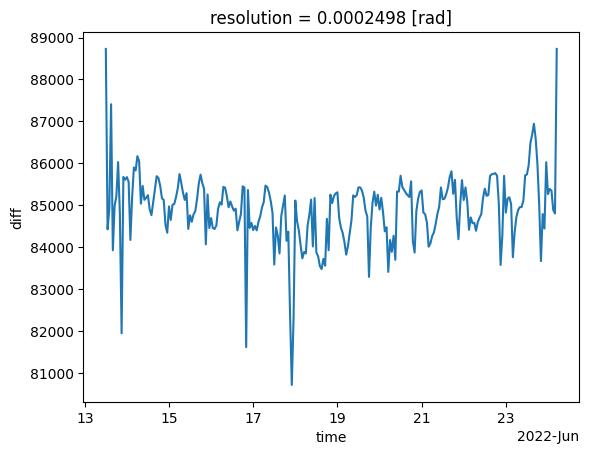

In [23]:
# This cell verifies the regridded data by plotting the count of non-NaN values.
regridded["diff"].count(["cells"]).plot()

In [24]:
%%time
regridded.to_zarr(
    f"{target_root}/diff-regridded-1D.zarr",
    mode="w",
    consolidated=True,
    compute=True,
    storage_options=storage_options,
)

# Cleanup unnecessary variables to free up memory
del ds, grid, target_grid, regridder, regridded

/home/ecap/micromamba/envs/pangeo-fish/lib/python3.11/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 13.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 122 ms, sys: 38.2 ms, total: 161 ms
Wall time: 732 ms


## 4. **Construct Emission Matrix:** Create an emission matrix based on the transformed 1D grid.

In this step, we construct the emission probability matrix based on the differences between the observed tag temperature and the reference sea temperature computed in Workflow 2 and regridded in Workflow 3. The emission probability matrix represents the likelihood of observing a specific temperature difference given the model parameters and configurations.


In [25]:
# Import necessary libraries
from toolz.dicttoolz import valfilter
from pangeo_fish.distributions import create_covariances
from pangeo_fish.distributions.healpix import normal_at
from pangeo_fish.pdf import normal
import xdggs

In [26]:
%%time
# Open the regridded diff data
differences = xr.open_dataset(
    f"{target_root}/diff-regridded-1D.zarr",
    engine="zarr",
    chunks={},
    storage_options=storage_options,
).pipe(lambda ds: ds.merge(ds[["latitude", "longitude"]].compute()))
differences
# Set required attributes cleanly
differences["cell_ids"].attrs["grid_name"] = "healpix"
# get existing attrs 
attrs_to_keep = ["level", "grid_name"]
# keep only specified attrs
differences["cell_ids"].attrs = {key: value for key, value in differences["cell_ids"].attrs.items() if key in attrs_to_keep}

differences = differences.pipe(xdggs.decode)
differences

CPU times: user 56.3 ms, sys: 3.01 ms, total: 59.3 ms
Wall time: 293 ms


<xarray.Dataset> Size: 235MB
Dimensions:     (cells: 111617, time: 258)
Coordinates:
  * cell_ids    (cells) int64 893kB 56064943 56064954 ... 57955392 57955456
    latitude    (cells) float64 893kB 46.02 46.03 46.02 ... 50.98 50.98 50.98
    longitude   (cells) float64 893kB -1.066 -1.042 -3.078 ... -7.507 -7.722
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    H0          (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    diff        (time, cells) float64 230MB dask.array<chunksize=(24, 111617), meta=np.ndarray>
    ocean_mask  (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

In [27]:
%%time
# Compute initial and final position
grid = differences[["latitude", "longitude"]].compute()
  #print(grid['cell_ids'])
initial_position = tag["tagging_events"].ds.sel(event_name="release")
#cov = create_covariances(1e-6, coord_names=["latitude", "longitude"])
# sigma 1e-3**2 in the calculation
initial_probability = normal_at(grid, pos=initial_position, sigma=1e-3)

final_position = tag["tagging_events"].ds.sel(event_name="fish_death")
if final_position[["longitude", "latitude"]].to_dataarray().isnull().all():
    final_probability = None
else:
    final_probability = normal_at(grid, pos=final_position, sigma=recapture_std)

CPU times: user 31.8 ms, sys: 0 ns, total: 31.8 ms
Wall time: 25.2 ms


In [28]:
grid
print(grid)

<xarray.Dataset> Size: 3MB
Dimensions:     (cells: 111617)
Coordinates:
    latitude    (cells) float64 893kB 46.02 46.03 46.02 ... 50.98 50.98 50.98
    longitude   (cells) float64 893kB -1.066 -1.042 -3.078 ... -7.507 -7.722
  * cell_ids    (cells) int64 893kB 56064943 56064954 ... 57955392 57955456
    resolution  float64 8B 0.0002498
Dimensions without coordinates: cells
Data variables:
    *empty*
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0


In [29]:
%%time
# compute emission probability matrix

emission_pdf = (
    normal(differences["diff"], mean=0, std=differences_std, dims=["cells"])
    .to_dataset(name="pdf")
    .assign(
        valfilter(
            lambda x: x is not None,
            {
                "initial": initial_probability,
                "final": final_probability,
                "mask": differences["ocean_mask"],
            },
        )
    )
    .assign_attrs(differences.attrs)  # | {"max_sigma": max_sigma})
)

emission_pdf = emission_pdf.chunk(default_chunk_cells).persist()
emission_pdf

CPU times: user 17.8 ms, sys: 0 ns, total: 17.8 ms
Wall time: 17.4 ms


<xarray.Dataset> Size: 236MB
Dimensions:     (cells: 111617, time: 258)
Coordinates:
  * cell_ids    (cells) int64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    latitude    (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    longitude   (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    pdf         (time, cells) float64 230MB dask.array<chunksize=(24, 111617), meta=np.ndarray>
    initial     (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    final       (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    mask        (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

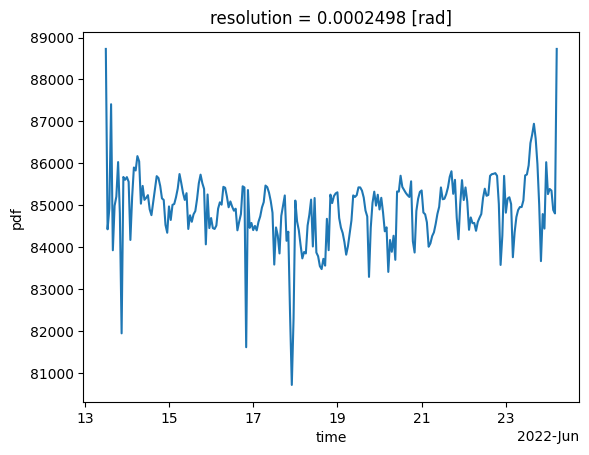

In [30]:
# Verify the data
emission_pdf["pdf"].count(["cells"]).plot()

In [31]:
# This cell saves the emission data to Zarr format, then cleans up unnecessary variables to free up memory.

emission_pdf.to_zarr(
    f"{target_root}/emission_1D.zarr",
    mode="w",
    consolidated=True,
    storage_options=storage_options,
)


del differences, grid, initial_probability, final_probability, emission_pdf

## 5. **Compute Additional Emission Probability Matrix:** Calculate an additional emission probability matrix, particularly focusing on teledetection from acoustic signals.

In this step, we compute additional emission probabilities based on acoustic detections for the selected tag. These additional probabilities enhance the emission probability matrix constructed in step 4 by incorporating information from acoustic telemetry.

In [32]:
%%time
# Import necessary libraries and open data and perform initial setup
from pangeo_fish import acoustic, utils
import hvplot.xarray

emission = xr.open_dataset(
    f"{target_root}/emission_1D.zarr",
    engine="zarr",
    chunks={},  # "x": -1, "y": -1},
    storage_options=storage_options,
)
emission

CPU times: user 1.36 s, sys: 26.2 ms, total: 1.39 s
Wall time: 1.53 s


<xarray.Dataset> Size: 236MB
Dimensions:     (cells: 111617, time: 258)
Coordinates:
    cell_ids    (cells) int64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    latitude    (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    longitude   (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    initial     (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    mask        (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    pdf         (time, cells) float64 230MB dask.array<chunksize=(24, 111617), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

In [33]:
%%time
# Construct the emission probabilities based on acoustic detections
#emission.cell_ids.lat=0
emission.cell_ids.attrs['lat'] = 0
emission.cell_ids.attrs['lon'] = 0

acoustic_pdf = acoustic.emission_probability(
    tag,
    emission[["time", "cell_ids", "mask"]].compute(),
    receiver_buffer,
    nondetections="mask",
    chunk_time=chunk_time,
    cell_ids="keep",
    dims=["cells"]
)

acoustic_pdf = acoustic_pdf.persist()
print(acoustic_pdf)

<xarray.Dataset> Size: 233MB
Dimensions:     (cells: 111617, time: 258)
Coordinates:
    longitude   (cells) float64 893kB -1.066 -1.042 -3.078 ... -7.507 -7.722
    latitude    (cells) float64 893kB 46.02 46.03 46.02 ... 50.98 50.98 50.98
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
    cell_ids    (cells) int64 893kB 56064943 56064954 ... 57955392 57955456
Dimensions without coordinates: cells
Data variables:
    acoustic    (time, cells) float64 230MB dask.array<chunksize=(1, 111617), meta=np.ndarray>
CPU times: user 11.1 s, sys: 2.02 s, total: 13.2 s
Wall time: 13.3 s


/home/ecap/micromamba/envs/pangeo-fish/lib/python3.11/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 1.10 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [34]:
# Verify the data and visualize the acoustic detections
tag["acoustic"]["deployment_id"].hvplot.scatter(c="red", marker="x") * (
    acoustic_pdf["acoustic"] != 0
).sum(dim=("cells")).hvplot()

:Overlay
   .Scatter.I :Scatter   [time]   (deployment_id)
   .Curve.I   :Curve   [time]   (acoustic)

In [35]:
acoustic_pdf["acoustic"].count(dim=("cells")).hvplot()

:Curve   [time]   (acoustic)

In [36]:
# Merge and save the combined emission probability matrix with acoustic probabilities

combined = emission.merge(acoustic_pdf)
combined

<xarray.Dataset> Size: 466MB
Dimensions:     (cells: 111617, time: 258)
Coordinates:
    cell_ids    (cells) int64 893kB 56064943 56064954 ... 57955392 57955456
    latitude    (cells) float64 893kB 46.02 46.03 46.02 ... 50.98 50.98 50.98
    longitude   (cells) float64 893kB -1.066 -1.042 -3.078 ... -7.507 -7.722
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    initial     (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    mask        (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    pdf         (time, cells) float64 230MB dask.array<chunksize=(24, 111617), meta=np.ndarray>
    acoustic    (time, cells) float64 230MB dask.array<chunksize=(1, 111617), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

In [37]:
combined.initial

<xarray.DataArray 'initial' (cells: 111617)> Size: 893kB
dask.array<open_dataset-initial, shape=(111617,), dtype=float64, chunksize=(111617,), chunktype=numpy.ndarray>
Coordinates:
    cell_ids    (cells) int64 893kB 56064943 56064954 ... 57955392 57955456
    latitude    (cells) float64 893kB 46.02 46.03 46.02 ... 50.98 50.98 50.98
    longitude   (cells) float64 893kB -1.066 -1.042 -3.078 ... -7.507 -7.722
    resolution  float64 8B 0.0002498
Dimensions without coordinates: cells

In [38]:
# This cell saves the emission data to Zarr format, then cleans up unnecessary variables to free up memory.

combined.to_zarr(
    f"{target_root}/emission_1D_acoustic.zarr",
    mode="w",
    consolidated=True,
    storage_options=storage_options,
)
# cleanup

del emission, acoustic_pdf, combined

## 6. **Combine and Normalize Emission Matrix:** Merge the emission matrix and normalize it for further processing.

In this step, we combine the emission probability matrix constructed in Workflow 4 and 5 then normalize it to ensure that the probabilities sum up to one. This step prepares the combined emission matrix for further analysis and interpretation.


In [39]:
# Import necessary libraries
from pangeo_fish.pdf import combine_emission_pdf
import hvplot.xarray

In [40]:
# Open and combine the emission probability matrix

combined = (
    xr.open_dataset(
        f"{target_root}/emission_1D_acoustic.zarr",
        engine="zarr",
        chunks=default_chunk_cells,
        inline_array=True,
        storage_options=storage_options,
    )
    .pipe(combine_emission_pdf)
    .chunk(default_chunk_cells)
    .persist()  # convert to comment if the emission matrix does *not* fit in memory
)
combined
print(combined.pdf.values)

[[5.13272427e-34 2.82003612e-33 4.50939615e-15 ... 2.28887123e-05
  2.66372022e-05 1.81314967e-05]
 [           nan            nan 9.12139553e-16 ... 1.60055785e-05
  1.94309170e-05 1.20892144e-05]
 [           nan            nan 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [           nan            nan 2.50945785e-26 ... 2.11187308e-09
  1.79805094e-09 1.69150385e-09]
 [           nan            nan 1.91037617e-26 ... 7.01177992e-09
  6.50467691e-09 6.60625113e-09]
 [2.25989815e-65 4.23408429e-66 1.26333263e-30 ... 7.55870957e-14
  1.19919649e-13 5.75360093e-14]]


In [41]:
# Verify the data and visualize the sum of probabilities
combined["pdf"].sum(["cells"]).hvplot(width=400)

:Curve   [time]   (pdf)

In [42]:
# Save the combined and normalized emission matrix
combined.to_zarr(
    f"{target_root}/combined_1D.zarr",
    mode="w",
    consolidated=True,
    storage_options=storage_options,
)
del combined

## 7. **Estimate Model Parameters:** Determine the parameters of the model based on the normalized emission matrix.

This step first estimates maxixmum allowed value of  model parameter 'sigma' max_sigma.  Then we
create an optimizer with an expected parameter range, fitting the model to the normalized emission matrix.  
The resulting optimized parameters is saved to a json file.  

In [43]:
# Import necessary libraries and modules for data analysis.
import xarray as xr
import pandas as pd
from pangeo_fish.hmm.estimator import EagerEstimator
from pangeo_fish.hmm.optimize import EagerBoundsSearch
from pangeo_fish.utils import temporal_resolution
from pangeo_fish.hmm.estimator import EagerEstimator
from pangeo_fish.hmm.prediction import Gaussian1DHealpix
from tlz.functoolz import curry
# Open the data
emission = xr.open_dataset(
    f"{target_root}/combined_1D.zarr",
    engine="zarr",
    chunks={},
    inline_array=True,
    storage_options=storage_options,
)
emission

<xarray.Dataset> Size: 236MB
Dimensions:     (cells: 111617, time: 258)
Coordinates:
    cell_ids    (cells) int64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    latitude    (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    longitude   (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    initial     (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    mask        (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    pdf         (time, cells) float64 230MB dask.array<chunksize=(24, 111617), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

In [44]:
# Compute maximum displacement for each reference model time step
# and estimate maximum sigma value for limiting the optimisation step

earth_radius_ = xr.DataArray(earth_radius, dims=None)

timedelta = temporal_resolution(emission["time"]).pint.quantify().pint.to("h")
grid_resolution = earth_radius_ * emission["resolution"].pint.quantify()

maximum_speed_ = xr.DataArray(maximum_speed, dims=None).pint.to("km / h")
max_grid_displacement = maximum_speed_ * timedelta * adjustment_factor / earth_radius_
max_sigma = max_grid_displacement.pint.to("dimensionless").pint.magnitude / truncate
emission.attrs["max_sigma"] = max_sigma.item()
max_sigma

/home/ecap/pangeo-fish/pangeo_fish/utils.py:122: FutureWarning: Hour.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  timedelta = to_offset(freq).delta.to_numpy()


np.float64(0.0004905038455501491)

In [45]:
## Create and configure estimator and optimizer
import xdggs
emission = (
    emission.compute()
)  # Convert to comment if the emission matrix does *not* fit in memory

# Set required attributes cleanly
emission["cell_ids"].attrs["grid_name"] = "healpix"
# Récupérer les attributs existants de cell_ids
attrs_to_keep = ["level", "grid_name"]
# should also have nest
emission["cell_ids"].attrs = {key: value for key, value in emission["cell_ids"].attrs.items() if key in attrs_to_keep}

print(emission["cell_ids"].attrs)
emission = emission.pipe(xdggs.decode)

predictor_factory = curry(
    Gaussian1DHealpix,
    cell_ids=emission["cell_ids"].data,
    grid_info=emission.dggs.grid_info,
    truncate=4.0,
    weights_threshold=1e-8,
    pad_kwargs={"mode": "constant", "constant_value": 0},
    optimize_convolution=True,
)

estimator = EagerEstimator(
    sigma=None, predictor_factory=predictor_factory
)
optimizer = EagerBoundsSearch(
    estimator,
    (1e-4, emission.attrs["max_sigma"]),
    optimizer_kwargs={"disp": 3, "xtol": tolerance},
)

{'grid_name': 'healpix', 'level': 12}


In [46]:
%%time
# Fit the model parameter to the data
optimized = optimizer.fit(emission)

 
 Func-count     x          f(x)          Procedure
    1    0.000249159      2338.67        initial
    2    0.000341345      2337.51        golden
    3    0.000398318      2339.45        golden
    4     0.00031537      2337.67        parabolic
    5    0.000360427      2337.45        parabolic
    6      0.0003749      2339.29        golden
    7    0.000353138      2337.47        golden
    8    0.000365955      2337.44        golden
    9    0.000369372      2337.43        golden
   10    0.000371484      2337.43        golden
   11    0.000372789      2337.43        golden
   12    0.000373595      2337.43        golden
   13    0.000374094      2337.43        golden
   14    0.000374427      2337.43        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-06 )
CPU times: user 2min 47s, sys: 15.4 s, total: 3min 2s
Wall time: 2min 58s


In [47]:
# Save the optimized parameters
params = optimized.to_dict()
pd.DataFrame.from_dict(params, orient="index").to_json(
    f"{target_root}/parameters.json", storage_options=storage_options
)

In [48]:
# Cleanup
del optimized, emission

## 8. **Compute State Probabilities and Tracks:** Calculate the probability distribution of the species in question and compute the tracks.

This step involves predicting state probabilities using the optimised parameter sigma computed in the last step together with normalized emission matrix.  

In [64]:
# Import necessary libraries and modules for data analysis.
import xarray as xr
import pandas as pd
import hvplot.xarray
from pangeo_fish.hmm.estimator import EagerEstimator
from pangeo_fish.io import save_trajectories

# Recreate the Estimator
params = pd.read_json(
    f"{target_root}/parameters.json", storage_options=storage_options
).to_dict()[0] | {'predictor_factory':predictor_factory}
params.pop("predictor")
optimized = EagerEstimator(**params)
optimized.predictor_factory

<class 'pangeo_fish.hmm.prediction.Gaussian1DHealpix'>

In [65]:
%%time
# Load the Data
emission = xr.open_dataset(
    f"{target_root}/combined_1D.zarr",
    engine="zarr",
    chunks=default_chunk_cells,
    inline_array=True,
    storage_options=storage_options,
).compute()

# Predict the State Probabilities

states = optimized.predict_proba(emission)
states = states.to_dataset().chunk(default_chunk_cells).persist()
states

CPU times: user 20.8 s, sys: 3.59 s, total: 24.4 s
Wall time: 23.9 s


/home/ecap/micromamba/envs/pangeo-fish/lib/python3.11/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 222.26 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.Dataset> Size: 233MB
Dimensions:     (cells: 111617, time: 258)
Coordinates:
    cell_ids    (cells) int64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    latitude    (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    longitude   (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    states      (time, cells) float64 230MB dask.array<chunksize=(24, 111617), meta=np.ndarray>

In [66]:
# Verify the data and visualize the sum of probabilities
plot = states.sum(["cells"]).hvplot() + states.count(["cells"]).hvplot()
hvplot.save(plot, f"{target_root}/states_count_1D.html")

In [68]:
%%time
# Save probability distirbution, state matrix.
states.chunk(default_chunk_cells).to_zarr(
    f"{target_root}/states_1D.zarr",
    mode="w",
    consolidated=True,
    storage_options=storage_options,
)
print(f"{target_root}/states_1D.zarr")
states

./A19124/states_1D.zarr
CPU times: user 18.4 ms, sys: 30.4 ms, total: 48.8 ms
Wall time: 110 ms


<xarray.Dataset> Size: 233MB
Dimensions:     (cells: 111617, time: 258)
Coordinates:
    cell_ids    (cells) int64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    latitude    (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    longitude   (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    states      (time, cells) float64 230MB dask.array<chunksize=(24, 111617), meta=np.ndarray>

In [69]:
%%time
# decode tracks

trajectories = optimized.decode(
    emission,
    states.fillna(0),
    mode=track_modes,
    progress=False,
    additional_quantities=additional_track_quantities,
)
trajectories

CPU times: user 384 ms, sys: 40 ms, total: 424 ms
Wall time: 618 ms


TrajectoryCollection with 2 trajectories

In [70]:
# Save trajectories.
# Here we can chose format parquet for loading files from 'R'
# or chose to  format 'geoparquet' for further analysis of tracks using
# geopands.

save_trajectories(trajectories, target_root, storage_options, format="parquet")

In [ ]:
# Cleanup
del optimized, emission, states, trajectories

## 9. **Visualization:** Visualize the results of the analysis for interpretation and insight.


In this step, we visualize various aspects of the analysis results to gain insights and interpret the model outcomes. We plot the emission matrix, which represents the likelihood of observing a specific temperature difference given the model parameters and configurations. Additionally, we visualize the state probabilities, showing the likelihood of the system being in different states at each time step. We also plot each of the tracks of the tagged fish, displaying their movement patterns over time. Finally, we create a movie that combines the emission matrix and state probabilities to provide a comprehensive visualization of the analysis results.


In [71]:
# Import necessary libraries
import holoviews as hv
import hvplot.xarray
import cmocean
import xmovie
from pangeo_fish import visualization
from pangeo_fish.io import read_trajectories, save_html_hvplot

In [72]:
%time
# load trajectories
trajectories = read_trajectories(
    track_modes, target_root, storage_options, format="parquet"
)
print(trajectories)
# Plot trajectoriesand plot.

plots = [
    traj.hvplot(
        c="speed",
        tiles="CartoLight",
        title=traj.id,
        cmap="cmo.speed"
        #                ,xlim=bbox['longitude'],        ylim=bbox['latitude']
        ,
        width=300,
        height=300,
    )
    for traj in trajectories.trajectories
]
plot = hv.Layout(plots).cols(2)

filepath = f"{target_root}/trajectories.html"
save_html_hvplot(plot, filepath, storage_options)

plot

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 3.81 μs
TrajectoryCollection with 2 trajectories


:Layout
   .Overlay.I  :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Path.I   :Path   [Longitude,Latitude]   (speed)
      .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)
   .Overlay.II :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Path.I   :Path   [Longitude,Latitude]   (speed)
      .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

In [ ]:
states_1D= xr.open_dataset('A19124/states_1D.zarr',
                           engine="zarr",
                           chunks={},
                           inline_array=True,
                           storage_options=None,
                        )

In [77]:
# Set required attributes cleanly
states_1D["cell_ids"].attrs["grid_name"] = "healpix"
#emission_1D["cell_ids"].attrs["nest"] = True
# Récupérer les attributs existants de cell_ids
attrs_to_keep = ["level", "grid_name"]
# should also have nest
states_1D["cell_ids"].attrs = {key: value for key, value in states_1D["cell_ids"].
                              attrs.items() if key in attrs_to_keep}
states_1D

<xarray.Dataset> Size: 233MB
Dimensions:     (cells: 111617, time: 258)
Coordinates:
    cell_ids    (cells) int64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    latitude    (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    longitude   (cells) float64 893kB dask.array<chunksize=(111617,), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    states      (time, cells) float64 230MB dask.array<chunksize=(24, 111617), meta=np.ndarray>

In [85]:
states_1D.pipe(xdggs.decode).isel(time=-1).compute().states.dggs.explore(alpha=0.8)

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [ ]:
%%time
# load files for plotting

emission = (
    xr.open_dataset(
        f"{target_root}/emission.zarr",
        engine="zarr",
        chunks={},
        inline_array=True,
        storage_options=storage_options,
    )
    .rename_vars({"pdf": "emission"})
    .drop_vars(["final", "initial"])
)  # .where(emission["mask"])
states = xr.open_dataset(
    f"{target_root}/states_cells.zarr",
    engine="zarr",
    chunks={},
    inline_array=True,
    storage_options=storage_options,
).where(emission["mask"])
data = xr.merge([states, emission.drop_vars(["mask"])])

# visualize states and emission matrix.  Save the visualisation in an html file.
#
plot1 = visualization.plot_map(data["states"], bbox)
plot2 = visualization.plot_map(data["emission"], bbox)
plot = hv.Layout([plot1, plot2]).cols(2)
filepath = f"{target_root}/states_emission.html"

plot

In [ ]:
%%time
## Create Movies
#
mov = xmovie.Movie(
    (
        data.isel(time=slice(0, data.time.size - 1, time_step))
        .chunk({"time": 1, "x": -1, "y": -1})
        .pipe(lambda ds: ds.merge(ds[["longitude", "latitude"]].compute()))
    ).pipe(visualization.filter_by_states),
    plotfunc=visualization.create_frame,
    input_check=False,
    pixelwidth=15 * 400,
    pixelheight=12 * 400,
    dpi=400,
)
## workaround dueto https://github.com/jbusecke/xmovie/issues/162
# use local file system

if target_root.startswith("s3://"):
    !mkdir -p movie
    mov.save(
        f"./movie/states.mp4",
        overwrite_existing=True,
    )
    import s3fs

    s3 = s3fs.S3FileSystem(**storage_options)
    s3.put_file(f"./movie/states.mp4", f"{target_root}/states.mp4")
else:
    mov.save(
        f"{target_root}/states.mp4",
        overwrite_existing=True,
    )